## [MLSP 2014 Schizophrenia Classification Challenge](https://www.kaggle.com/competitions/mlsp-2014-mri/overview)

### Exploration of GNN with Schizophrenia Dataset

#### Understanding the data
<p align = center>
<img src = "images/brain.png" width = 600>
</p>

Picture credits: Chu, SH., Parhi, K.K. & Lenglet, C. Function-specific and Enhanced Brain Structural Connectivity Mapping via Joint Modeling of Diffusion and Functional MRI. Sci Rep 8, 4741 (2018). https://doi.org/10.1038/s41598-018-23051-9


**FNC Features (Functional):**

- Represent pairwise correlations between ICA brain maps (nodes).
- These are well-suited to be modeled as edge weights in a graph.

**SBM Features (Structural):**
- Represent loadings of ICA components, per subject.
- Could be used as node-level features, describing each node (brain region’s gray matter concentration).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_mean_pool

In [ ]:
# Load the FNC edge-to-node mapping
fnc_map = pd.read_csv("data/AdditionalInformation/rs_fMRI_FNC_mapping.csv")

# Create 0-based node indexing
unique_nodes = pd.unique(fnc_map[['mapA', 'mapB']].values.ravel())
unique_nodes.sort()
node_id_map = {orig: idx for idx, orig in enumerate(unique_nodes)}

# Apply mapping to edge definitions
fnc_map['node1'] = fnc_map['mapA'].map(node_id_map)
fnc_map['node2'] = fnc_map['mapB'].map(node_id_map)

# Extract edge list
edge_index_list = fnc_map[['node1', 'node2']].values.T  # shape [2, num_edges]

In [234]:
# Load subject data
fnc_df = pd.read_csv("data/train_FNC.csv")
labels_df = pd.read_csv("data/train_labels.csv")
node_df= pd.read_csv("data/train_node.csv")
sbm_df = pd.read_csv("data/train_SBM.csv")

edge_index_list = fnc_map[['node1', 'node2']].values.T
edge_index = torch.tensor(edge_index_list, dtype=torch.long)
node_df = node_df.sort_values("Node").reset_index(drop=True)
node_features = torch.tensor(node_df[['x', 'y', 'z']].values, dtype=torch.float)  # shape: [28, 3]

data_df = fnc_df.merge(labels_df, on="Id")

In [259]:
graphs = []

for _, row in data_df.iterrows():
    subject_id = row["Id"]
    label = row["Class"]

    fnc_values = row.filter(like="FNC").values
    edge_attr = torch.tensor(fnc_values, dtype=torch.float).view(-1, 1)

    sbm_row = sbm_df[sbm_df["Id"] == subject_id]
    if sbm_row.empty:
        continue

    sbm_vector = sbm_row.drop(columns=["Id"]).values.flatten()
    sbm_tensor = torch.tensor(sbm_vector, dtype=torch.float).view(1, -1)  # shape [1, 32]
 
    graph = Data(
        x=node_features.clone(),
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor([label], dtype=torch.long),
        sbm=sbm_tensor
    )
    graph.subject_id = subject_id
    graphs.append(graph)

In [ ]:
def plot_3d_brain_graph_plotly(graph, title=None, edge_threshold=0.1):
    coords = graph.x.numpy()          # [28, 3]
    edge_index = graph.edge_index.T   # [378, 2]
    edge_weights = graph.edge_attr.numpy().flatten()

    # Prepare edge traces
    edge_lines = []
    edge_colors = []
    for i, (src, tgt) in enumerate(edge_index):
        w = edge_weights[i]

        if abs(w) < edge_threshold:
            color = 'lightgray'
        elif w > 0:
            color = 'blue'
        else:
            color = 'red'

        x0, y0, z0 = coords[src]
        x1, y1, z1 = coords[tgt]
        edge_lines.append(go.Scatter3d(
            x=[x0, x1, None],
            y=[y0, y1, None],
            z=[z0, z1, None],
            mode='lines',
            line=dict(color=color, width=4 if abs(w) > edge_threshold else 2),
            hoverinfo='none',
            showlegend=False
        ))

    # Node trace
    node_trace = go.Scatter3d(
        x=coords[:, 0],
        y=coords[:, 1],
        z=coords[:, 2],
        mode='markers',
        marker=dict(size=6, color='skyblue'),
        name='ICA Nodes',
        hoverinfo='text'
    )

    # Create figure
    fig = go.Figure(data=[*edge_lines, node_trace])

    fig.update_layout(
        title=title or f"3D Brain Graph - Label: {graph.y.item()}",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        showlegend=True
    )

    fig.show()

In [261]:
i= 3
plot_3d_brain_graph_plotly(
    graphs[i],
    title=f"Subject {graphs[i].subject_id}, Label {graphs[i].y.item()}"
)

<Axes: xlabel='Class', ylabel='count'>

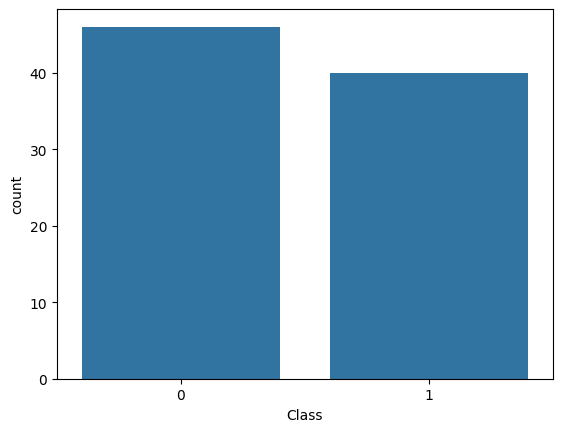

In [7]:
sns.countplot(data=labels_df, x="Class")

In [262]:
# Extract labels for stratification
labels = [g.y.item() for g in graphs]

# Stratified split
train_graphs, test_graphs = train_test_split(
    graphs, test_size=0.2, stratify=labels, random_state=42
)

In [242]:
print(graph)

Data(x=[28, 3], edge_index=[2, 378], edge_attr=[378, 1], y=[1], sbm=[32], subject_id=993946.0)


In [263]:
# Create batched loaders
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=2, shuffle=False)

In [269]:
class GNNWithEdgeAttrsAndSBM(nn.Module):
    def __init__(self, in_channels=3, edge_dim=1, sbm_dim=32, hidden_dim=256):
        super().__init__()

        # First NNConv layer
        self.edge_nn1 = nn.Sequential(
            nn.Linear(edge_dim, 128),
            nn.ReLU(),
            nn.Linear(128, in_channels * hidden_dim)
        )
        self.conv1 = NNConv(in_channels, hidden_dim, self.edge_nn1, aggr='max')
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Second NNConv layer
        self.edge_nn2 = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, hidden_dim * hidden_dim)
        )
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='max')
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # Final classifier takes graph embedding + SBM vector
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + sbm_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        sbm = data.sbm
        if sbm.dim() == 1:
            sbm = sbm.unsqueeze(0)  # ensure batch dim

        # GNN layers
        x = F.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x = F.relu(self.bn2(self.conv2(x, edge_index, edge_attr)))

        # Graph-level embedding
        x = global_mean_pool(x, batch)

        # Concatenate SBM global features
        x = torch.cat([x, sbm], dim=1)

        x = self.dropout(x)
   
        return self.classifier(x)

In [270]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNNWithEdgeAttrsAndSBM(in_channels=3, edge_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()


# Global lists to log performance
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs

    acc = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(acc)
    return acc


def test(loader, is_test=True):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()

        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    acc = correct / len(loader.dataset)
    if is_test:
        test_losses.append(total_loss / len(loader))
        test_accuracies.append(acc)
    return acc, all_preds, all_labels

In [271]:
for epoch in range(1, 31):
    train_acc = train()
    test_acc, test_preds, test_labels = test(test_loader)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01 | Train Acc: 0.5294 | Test Acc: 0.5556
Epoch 02 | Train Acc: 0.6029 | Test Acc: 0.5000
Epoch 03 | Train Acc: 0.5735 | Test Acc: 0.7222
Epoch 04 | Train Acc: 0.7059 | Test Acc: 0.7222
Epoch 05 | Train Acc: 0.8382 | Test Acc: 0.8333
Epoch 06 | Train Acc: 0.7500 | Test Acc: 0.8333
Epoch 07 | Train Acc: 0.6765 | Test Acc: 0.7778
Epoch 08 | Train Acc: 0.8235 | Test Acc: 0.7778
Epoch 09 | Train Acc: 0.7794 | Test Acc: 0.7778
Epoch 10 | Train Acc: 0.7941 | Test Acc: 0.8333
Epoch 11 | Train Acc: 0.8529 | Test Acc: 0.7778
Epoch 12 | Train Acc: 0.7500 | Test Acc: 0.8333
Epoch 13 | Train Acc: 0.7941 | Test Acc: 0.8333
Epoch 14 | Train Acc: 0.8529 | Test Acc: 0.8333
Epoch 15 | Train Acc: 0.8088 | Test Acc: 0.8333
Epoch 16 | Train Acc: 0.8971 | Test Acc: 0.7778
Epoch 17 | Train Acc: 0.8824 | Test Acc: 0.8889
Epoch 18 | Train Acc: 0.8529 | Test Acc: 0.7778
Epoch 19 | Train Acc: 0.7794 | Test Acc: 0.7778
Epoch 20 | Train Acc: 0.8824 | Test Acc: 0.8889
Epoch 21 | Train Acc: 0.8529 | Test Acc:

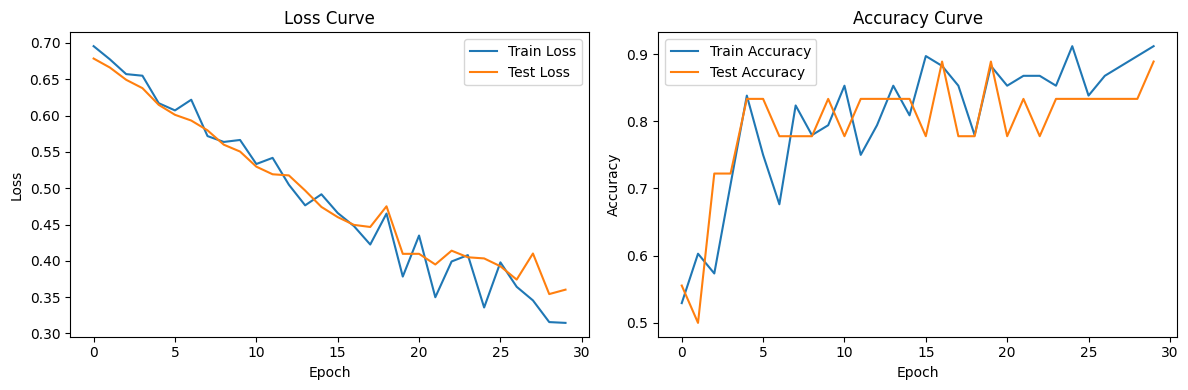

In [272]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")

plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

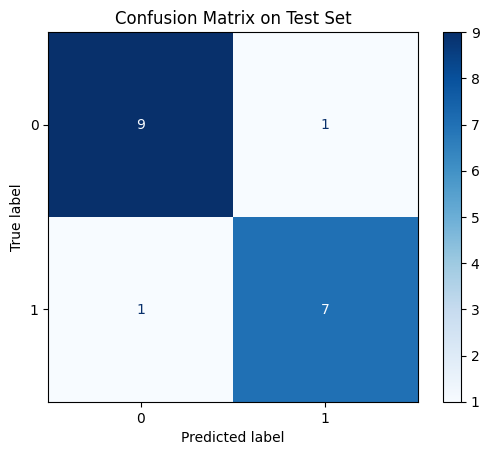

In [273]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()